# predict_T+1_tf2

## Base
### 依赖与超参数

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, BatchNormalization, \
    Flatten, Lambda, Permute, RepeatVector
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot

In [2]:
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 20
batch_size = 64
lstm_units = 64
conv_filters = 64
epoch = 10
dropout = 0.4

### 模型相关函数

In [3]:
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


# 多维归一化 返回数据和最大最小值
def NormalizeMult(data):
    normalize = np.arange(2 * data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1], 2)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        list_low, list_high = np.percentile(list, [0, 100])
        normalize[i, 0] = list_low
        normalize[i, 1] = list_high
        delta = list_high - list_low
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - list_low) / delta
    return data, normalize


# 多维反归一化
def FNormalizeMult(data, normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i] * delta + listlow

    return data

# 模型评估
def calculate_metrics(test_Y, pred_Y):
    mae = mean_absolute_error(test_Y, pred_Y)
    mse = mean_squared_error(test_Y, pred_Y)

    test_diff = np.diff(test_Y[:, 1])
    pred_diff = np.diff(pred_Y[:, 1])
    test_sign = np.sign(test_diff)
    pred_sign = np.sign(pred_diff)
    accuracy = np.mean(test_sign == pred_sign) * 100

    return mae, mse, accuracy

# 预测第二天价格-数据集创建
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

### 数据加载与划分

In [4]:
# 加载数据
data = pd.read_csv("./data.csv")
data = data[['open', 'close', 'high', 'low']]

# 归一化
data = np.array(data)
data, normalize = NormalizeMult(data)
close_column = data[:, 1].reshape(len(data), 1)

train_X, train_Y = create_dataset_tomorrow(data, TIME_STEPS)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

## 直接训练并运行

In [5]:
def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
model = attention_model()
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)

In [12]:
# 使用测试集进行预测
pred_Y_direct = model.predict(test_X)

pred_Y_denormalized_direct = FNormalizeMult(pred_Y_direct, normalize)
test_Y_denormalized_direct = FNormalizeMult(test_Y, normalize)

mae_direct, mse_direct, accuracy_direct = calculate_metrics(test_Y_denormalized_direct, pred_Y_denormalized_direct)
print(f"MAE: {mae_direct}")
print(f"MSE: {mse_direct}")
print(f"涨跌准确率: {accuracy_direct}%")

165/165 [==============================] - 2s 6ms/step
MAE: 0.0051256491632018526
MSE: 5.765470677925419e-05
涨跌准确率: 98.72405256141687%


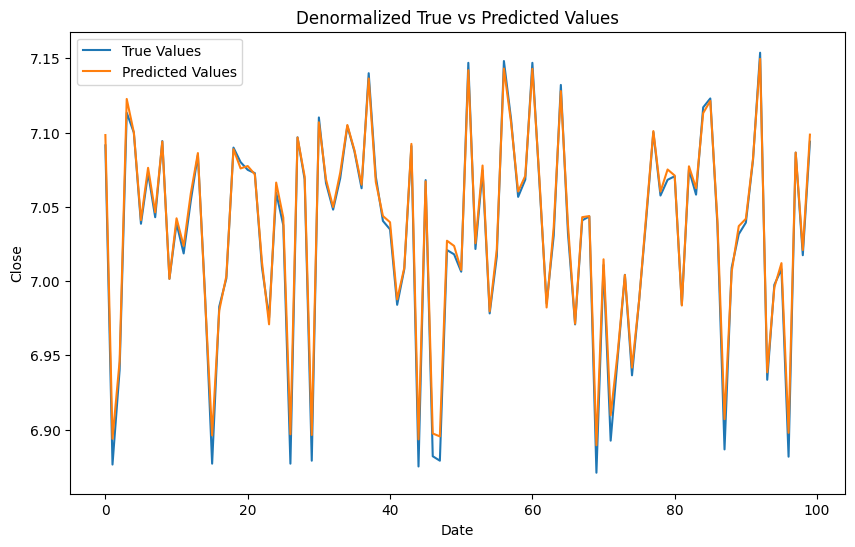

In [13]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_direct[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_direct[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [35]:
save_path_model = "check_points/saved_attention_model"
tf.saved_model.save(model, save_path_model)
model.save("check_points/attention_model")

INFO:tensorflow:Assets written to: check_points/saved_attention_model\assets


INFO:tensorflow:Assets written to: check_points/saved_attention_model\assets


INFO:tensorflow:Assets written to: check_points/attention_model\assets


INFO:tensorflow:Assets written to: check_points/attention_model\assets


In [9]:
model = tf.keras.models.load_model('check_points/attention_model')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 4)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 20, 64)               320       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 20, 64)               256       ['conv1d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_4 (Dropout)         (None, 20, 64)               0         ['batch_normalization_4[

In [10]:
widgets_map = {}

# 创建一个文件夹来存储权重
save_dir = "weights_npy"
os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在就创建

# 遍历每一层并保存权重
for layer_index, layer in enumerate(model.layers):
    weights = layer.get_weights()  # 获取权重和偏置
    if weights:  # 检查该层是否有权重
        print(weights)
        for i, weight in enumerate(weights):
            widgets_map[f'{layer.name}-{i}'] = weight
            # # 保存为 .npy 文件
            # filename = os.path.join(save_dir, f"layer_{layer_index + 1}_{layer.name}_weight_{i + 1}.npy")
            # np.save(filename, weight)

[array([[[ 0.00698605,  0.06122003, -0.03104588, -0.27034196,
         -0.2723038 ,  0.1711181 , -0.05522814,  0.05688442,
         -0.25549692, -0.08454755, -0.13013272,  0.08260336,
         -0.19221818, -0.09859325, -0.07001915, -0.16198172,
          0.04680238, -0.10247497, -0.01352233,  0.04713184,
          0.17670237, -0.21740155, -0.22184674, -0.11795684,
          0.04858842,  0.19374266, -0.01562196,  0.10191994,
         -0.16375986, -0.11961613,  0.11567813, -0.2783839 ,
         -0.27252087, -0.12770861, -0.08620161,  0.05093536,
          0.07078576,  0.06527884, -0.21736073,  0.03555681,
          0.16672195,  0.24556784,  0.07480773, -0.15728268,
          0.20707056,  0.14232364, -0.22115861, -0.02826439,
         -0.13921933, -0.2938841 ,  0.05132842, -0.03094796,
         -0.12557617, -0.22414778, -0.01826598,  0.05973913,
         -0.20776738, -0.06549717, -0.23705319, -0.27081648,
          0.186614  , -0.23120302,  0.07505623,  0.0089851 ],
        [ 0.15678161, 

## 使用丢番图逼近量化

In [22]:
from fractions import Fraction
    
def approximate_with_rational(matrix, precision):
    """
    使用连分数逼近量化矩阵中的浮点数，动态调整分母限制。

    参数:
        matrix (np.ndarray): 原始浮点数矩阵，可以是多维矩阵。
        max_denominator (int): 逼近的分母最大值。默认值为100。

    返回:
        np.ndarray: 量化后的矩阵，元素为 Fraction 类型。
    """

    # 映射函数：根据数值的大小映射出对应的最大分母限制
    def map_to_max_denominator(value):
        if value == 0: return 1
        abs_value = abs(value)
        d = 10**precision/abs_value
        d = int(d)
        return d

    def quantize_element(element):
        if isinstance(element, np.ndarray):  # 如果是子数组，递归处理
            return np.array([quantize_element(sub_elem) for sub_elem in element], dtype=object)
        else:
            # 使用映射函数来动态获取该元素的最大分母
            dynamic_denominator = map_to_max_denominator(element)
            # 量化该元素
            return Fraction(str(element)).limit_denominator(dynamic_denominator)

    return quantize_element(matrix)


# 递归地将量化后的权重矩阵中的每个 Fraction 转换为浮点数
def convert_fractions_to_floats(element):
    if isinstance(element, np.ndarray):  # 如果是子数组，递归处理
        return np.array([convert_fractions_to_floats(sub_elem) for sub_elem in element])
    elif isinstance(element, Fraction):  # 如果是分数，转换为浮点数
        return float(element)
    else:
        raise TypeError

quantized_weights_map = {}
quantized_float_weights_map = {}

for key, value in widgets_map.items():
    print(f"层名称: {key}")
    print(f"原始权重矩阵:\n{value}")
    quantized_weights = approximate_with_rational(value, precision=3) # 使用precision控制精度（类似于保留位数，这里意味着前precision位有效数字是准确的
    print(f"量化后的权重矩阵:\n{quantized_weights}")
    quantized_weights_map[key] = quantized_weights
    float_weights = convert_fractions_to_floats(quantized_weights)
    print(f"转换为浮点数的权重矩阵:\n{float_weights}")
    quantized_float_weights_map[key] = float_weights


层名称: conv1d_2-0
原始权重矩阵:
[[[ 0.00698605  0.06122003 -0.03104588 -0.27034196 -0.2723038
    0.1711181  -0.05522814  0.05688442 -0.25549692 -0.08454755
   -0.13013272  0.08260336 -0.19221818 -0.09859325 -0.07001915
   -0.16198172  0.04680238 -0.10247497 -0.01352233  0.04713184
    0.17670237 -0.21740155 -0.22184674 -0.11795684  0.04858842
    0.19374266 -0.01562196  0.10191994 -0.16375986 -0.11961613
    0.11567813 -0.2783839  -0.27252087 -0.12770861 -0.08620161
    0.05093536  0.07078576  0.06527884 -0.21736073  0.03555681
    0.16672195  0.24556784  0.07480773 -0.15728268  0.20707056
    0.14232364 -0.22115861 -0.02826439 -0.13921933 -0.2938841
    0.05132842 -0.03094796 -0.12557617 -0.22414778 -0.01826598
    0.05973913 -0.20776738 -0.06549717 -0.23705319 -0.27081648
    0.186614   -0.23120302  0.07505623  0.0089851 ]
  [ 0.15678161  0.1846521   0.16136634  0.02309829 -0.21297388
   -0.02067716  0.21511492  0.11854327  0.13688931  0.13666582
    0.19457956 -0.21431608 -0.10783194  0.05

In [23]:
quantize_model = tf.keras.models.load_model('check_points/attention_model')

In [24]:
def merge_layer_weights(weights_map):
    merged_weights = {}
    
    for key, value in weights_map.items():
        # 根据层的名称提取层编号
        layer_name = key.split("-")[0]  
        if layer_name in merged_weights.keys():
            list = merged_weights[layer_name]
            list.append(value)
            merged_weights[layer_name] = list
        else:
            list = []
            list.append(value)
            merged_weights[layer_name] = list
    
    return merged_weights

# 合并权重矩阵
merged_weights_map = merge_layer_weights(quantized_float_weights_map)

In [25]:
for key, value in merged_weights_map.items():   
    layer = quantize_model.get_layer(key)  
    layer.set_weights(value) 

In [26]:
# 使用测试集进行预测
pred_Y_quantized = quantize_model.predict(test_X)
pred_Y_denormalized_quantized = FNormalizeMult(pred_Y_quantized, normalize)
test_Y_denormalized_quantized = FNormalizeMult(test_Y, normalize)

# 计算评价指标
mae_quantized, mse_quantized, accuracy_quantized = calculate_metrics(test_Y_denormalized_quantized, pred_Y_denormalized_quantized)
print(f"MAE: {mae_quantized}")
print(f"MSE: {mse_quantized}")
print(f"涨跌准确率: {accuracy_quantized}%")

165/165 [==============================] - 2s 9ms/step
MAE: 0.005125816787079105
MSE: 5.765624961295362e-05
涨跌准确率: 98.72405256141687%


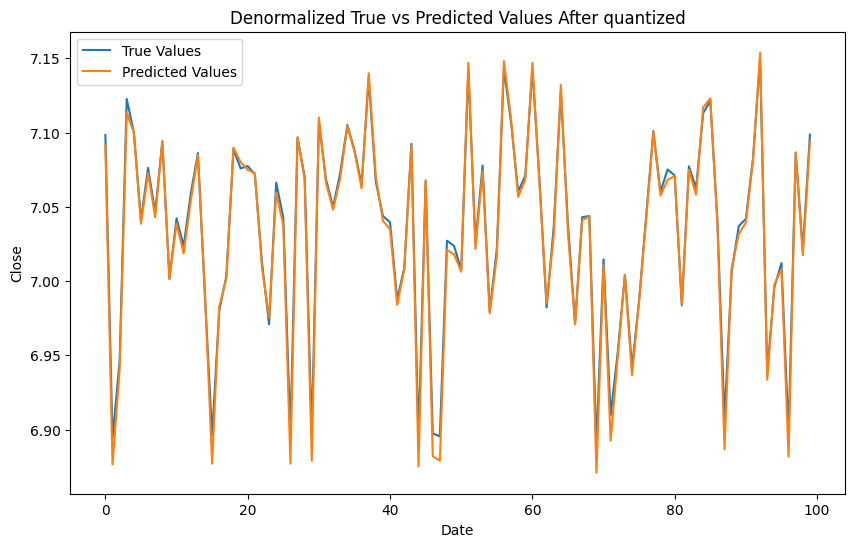

In [27]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(pred_Y_denormalized_quantized[:100, 1], label='True Values')
plt.plot(test_Y_denormalized_quantized[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values After quantized')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

## 使用官方库量化

### 量化模型（转为 TFLite 模型）

In [68]:
# 加载已保存的模型
converter = tf.lite.TFLiteConverter.from_saved_model(save_path_model)

save_path_quantization = 'tflite_models_direct_quantization'

# 启用量化
converter.optimizations = []  
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]  
converter._experimental_lower_tensor_list_ops = False  # 禁用 TensorList 的转换


def representative_data_gen():
    for input_value in train_X:
        yield [input_value.astype(np.float32)]

converter.representative_dataset = representative_data_gen

# 转换为量化的 TFLite 模型
tflite_model_quant = converter.convert()

In [69]:
# 保存量化后的模型
import pathlib
tflite_models_dir = pathlib.Path(f"check_points/{save_path_quantization}/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
size_quant = tflite_model_quant_file.write_bytes(tflite_model_quant)

print(f"Quantized model size: {size_quant} bytes")

Quantized model size: 397168 bytes


### 进行量化后模型的推理

In [66]:
def run_tflite_model(tflite_file, test_image_indices):
    global test_X, test_Y

    # 加载量化后的 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), 4), dtype=float)  # 假设输出是4个特征

    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_X[test_image_index]

        # 量化输入数据
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # 扩展维度并转换数据类型
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])

        # 将输入数据传入模型
        interpreter.set_tensor(input_details['index'], test_image)

        # 执行推理
        interpreter.invoke()

        # 获取输出
        output = interpreter.get_tensor(output_details['index'])[0]

        # 存储预测结果
        predictions[i] = output

    return predictions


test_indices = range(test_X.shape[0])
predictions = run_tflite_model(tflite_model_quant_file, test_indices)
pred_Y_denormalized_quant = FNormalizeMult(predictions, normalize)
test_Y_denormalized_quant = FNormalizeMult(test_Y, normalize)

mae_quant, mse_quant, accuracy_quant = calculate_metrics(test_Y_denormalized_quant, pred_Y_denormalized_quant)

print(f'Quantized Student model evaluation results:')
print(f"MAE: {mae_quant}")
print(f"MSE: {mse_quant}")
print(f"涨跌准确率: {accuracy_quant}%")


Quantized Student model evaluation results:
MAE: 0.0051256513903547435
MSE: 5.765476461225458e-05
涨跌准确率: 98.72405256141687%


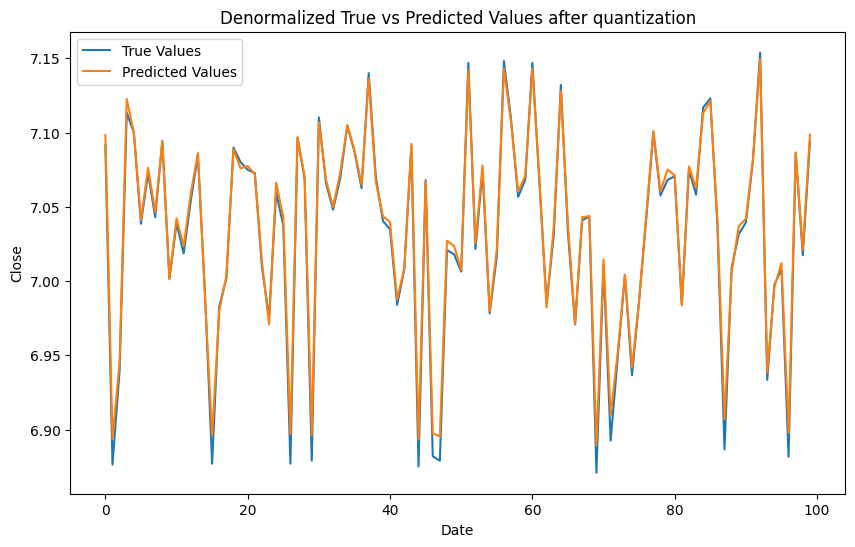

In [67]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_quant[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_quant[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values after quantization')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()